##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

Revision - 4/4/2022 | GH: Faiyaz42

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Style Transfer


![header image](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-header.jpg =512x) 

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to perform style transfer between two images, and show how different parameterizations affect that process.

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.research.google.com/drive/1XuxLjIZj9MV-lRCpXHBhLo5A41Zs0f8E), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


## Install, Import, Load Model

In [2]:
# Imports

print("DONT FREAK OUT IF RED ERROR MESSAGES APPEAR!!!! IT'S RE-CONFIGURING THE RUNTIME ENVIRONMENT,LET IT DO ITS THING! \n\n")

!pip install numpy==1.19.5

print("DONT FREAK OUT IF RED ERROR MESSAGES APPEAR!!!! IT'S RE-CONFIGURING THE RUNTIME ENVIRONMENT,LET IT DO ITS THING! \n\n")

!pip install lucid>=0.2.3


%tensorflow_version 1.x
import numpy as np
import tensorflow as tf                                            
from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render


"""
We will be writing a custom objective for style transfer, so let's grab this handy decorator that allows us to take a simple function 
and mark it as an objective in lucid:
"""

from lucid.optvis.objectives import wrap_objective

"""
And we'll use our default vision model, GoogLeNet:
"""

model = vision_models.InceptionV1()
model.load_graphdef()
model.layers



"""
You can use this to see if you're running on a machine with a correctly configured GPU:
"""

tf.test.is_gpu_available()

print("continuing to next code cell")


DONT FREAK OUT IF RED ERROR MESSAGES APPEAR!!!! IT'S RE-CONFIGURING THE RUNTIME ENVIRONMENT,LET IT DO ITS THING! 


  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.0
    Uninstalling numpy-1.19.0:
      Successfully uninstalled numpy-1.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


DONT FREAK OUT IF RED ERROR MESSAGES APPEAR!!!! IT'S RE-CONFIGURING THE RUNTIME ENVIRONMENT,LET IT DO ITS THING! 


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
TensorFlow 1.x selected.
continuing to next code cell


## Load input images

First, let's take a look at the two images we want to transfer styles between. This code should feel familiar from the Lucid tutorial:

Later in the notebook there'll be an opportunity to upload your own images, too.

(600, 600, 3) (600, 600, 3)



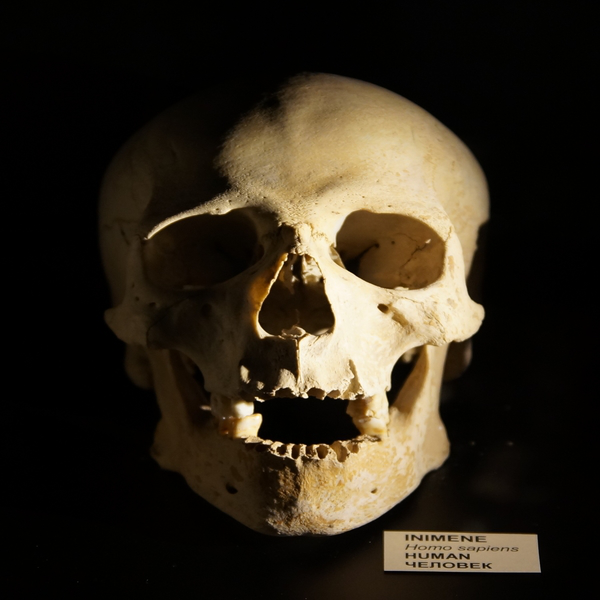


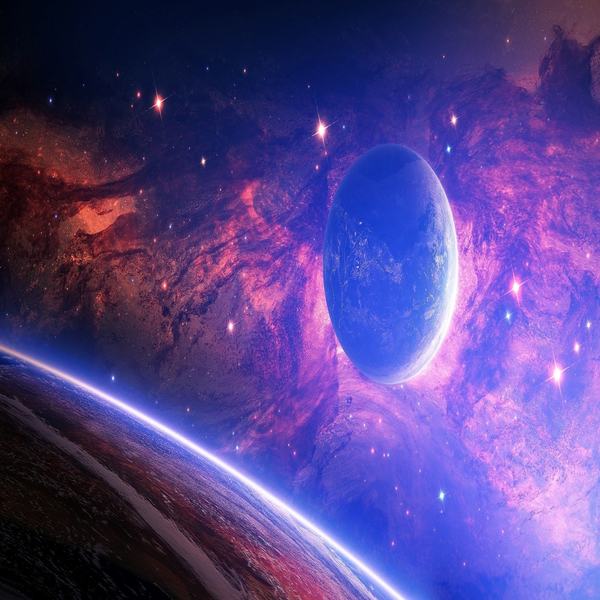

continuing to next code cell


In [3]:
content_image = load("https://i.ibb.co/nm6f0X3/Webp-net-resizeimage.jpg")[..., :3]  #Make sure your images have same height and width
style_image = load("https://i.ibb.co/c373tLg/Webp-net-resizeimage-2.jpg")[..., :3] 
print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)
print("continuing to next code cell")

## Introducing style transfer

In lucid, style transfer (rendering an image in the visual style of a different image) can be expressed compactly.

We feed two images, a **style image** and a **content image** into our model, which produces activations at all of its layers. 
From that we extract two subsets of activations, the style activations (orange) and the content activations (green), at different depths in the network. 

We then optimize an input to produce activations similar to the combined set of activations we extracted.

![styletransfer-diagram](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-diagram.png =563x)

Which layers work best for that is an aesthetic choice. Recommended reading: [Feature Visualization](https://distill.pub/2017/feature-visualization), in which the hero graphic shows what kind of visual concepts get captured at which layers in the model we are using.

In [4]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

To feed two images + one that is being optimized into our network we will use the batch dimension of a cutsom parameterization. It consists simply of the paramaterization of the optimized image stacked with the two images.

(We also use cropping to allow style images of a larger size than content images.)

In [5]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

Let's sanity check that shapes fit and the three inputs get stacked on their batch dimension correctly:

In [6]:
style_transfer_param(content_image, style_image).shape

TensorShape([Dimension(3), Dimension(600), Dimension(600), Dimension(3)])

Here we use `@wrap_objective` to create a custom `activation_difference` objective in lucid.
It takes as arguments the layer names specifying the subset of activations, and an image.
It will extract the specified subset of activations from both the supplied image and the one we are optimizing, and compute their difference.

Optionally one can pass a loss function defining how these differences should be penalized. By default, we penalize mean L1 difference.
Also, one can pass a function transforming the subset of activations. By default, we don't transform the activations.

In [7]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

In [8]:
@objectives.wrap_objective()
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

For the style loss, we do not care about the spatial information in the activations. Using a gram matrix to transform the activations before penalizing their difference works well for this:

In [9]:
def gram_matrix(array, normalize_magnitue=True):
    channels = tf.shape(array)[-1]
  
  
    array_flat = tf.reshape(array, [-1, channels])
    gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
    if normalize_magnitue:
      length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
    return gram_matrix



Now we have all the ingredients to set up an optimization in lucid: we will create two `activation_difference` objectives, a normal one for the **content loss**, and one transforming the activations using `gram_matrix` for the **style loss**.

In [10]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 90 * (activation_difference(content_layers, difference_to=CONTENT_INDEX))
content_obj.description = "Content Loss"

style_obj =  activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**If you get a numpy error, try restarting the runtime.**

In [11]:
show(vis)

Output hidden; open in https://colab.research.google.com to view.

That looks like style transfer to me!

## The influence of parameterization & transformation robustness

In the last rendering, we already used one of our differentiable parameterizations: a color decorrelated image in frequency space:

```python
param_f = lambda: param.image(width, height, decorrelate=True, fft=True)
```

(This parameterization has turned out to be so useful and stable that the last two arguments default to True in lucid. If you want to learn more, we describe it in [Feature Visualization](https://distill.pub/2017/feature-visualization/#preconditioning), and the module [`lucid.optvis.param.spatial`](https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py) contains our implementation "`fft_image()`".) 

We also—implicitly—used the [default robustness transforms](https://github.com/tensorflow/lucid/blob/master/lucid/optvis/transform.py#L138) built into lucid.

### Parameterization
It turns out that this parameterization is really important! Let's compare what happens when we try without these paramterizations first:

In [12]:
param_f = lambda: style_transfer_param(content_image, style_image, decorrelate=False, fft=False)

bad_param_vis = render.render_vis(model, objective, param_f, verbose=True, thresholds=(25, 75, 150, 300, 512), print_objectives=[content_obj, style_obj])[-1]

Output hidden; open in https://colab.research.google.com to view.


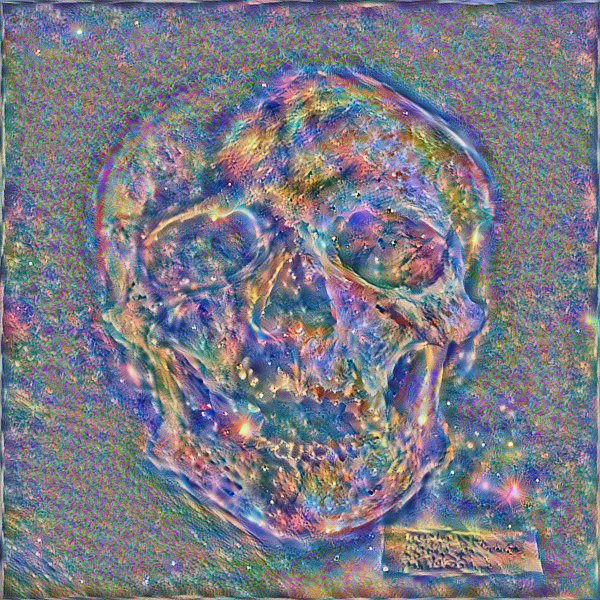

In [13]:
show(bad_param_vis[0])

### Transformation robustness

In [14]:
param_f = lambda: style_transfer_param(content_image, style_image, decorrelate=False, fft=False)

transforms = [] # specifying an empty array overrides default transformations

no_transforms_vis = render.render_vis(model, objective, param_f, transforms=transforms, verbose=True, thresholds=(25, 75, 150, 300, 512), print_objectives=[content_obj, style_obj])[-1]

Output hidden; open in https://colab.research.google.com to view.


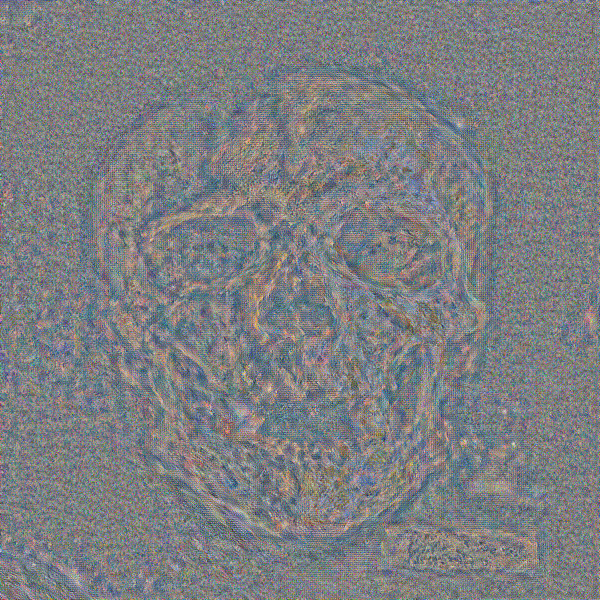

In [15]:
show(no_transforms_vis[0])

While these results still contains characteristics from both source images, you can tell that the optimization process has a much harder time getting to a good result.
The resulting image is affected by checkerboard artefacts. We wrote about transformation robustness in [Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) and about (at least one of the) underlying causes in [Checkerboard Artefacts](https://distill.pub/2016/deconv-checkerboard).


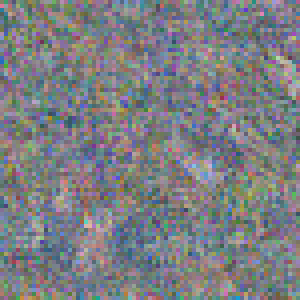

In [16]:
detail = no_transforms_vis[0][-75:, 125:200, ...] # just a manually selected part of the above visualization
zoomed4x = np.kron(detail, np.ones((4,4,1)))
show(zoomed4x)